# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

In [1]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

datasets = ['german', 'ionosphere', 'spambase','svmguide3','wpbc','wdbc','magic04','a8a']
model_types = ['opcbackprop','hinge_oco']


# initialize results dict
results = {}
masks = {}
occurrences = {}
instances_track = {}
for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    instances_track[dataset] ={}
    for model_type in model_types :
        results[dataset][model_type] = 0
        masks[dataset][model_type] = []
        
for scenario in p.scenarios:
    for dataset_name in p.datasets:
        for model_type in model_types:
            Xpath, ypath = dl.get_path(dataset_name)
            X, y = dl.read_dataset(Xpath, ypath)
            num_features = len(X[0])
            m = p.models[model_type](num_features, p.learning_rate, p.num_layers[0])
            fold_errors, fold_cum_error, instances, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario],p.cov_strength[scenario])
            masks[dataset_name][model_type] = fold_masks
            results[dataset_name][model_type] = fold_cum_error
            instances_track[dataset_name][model_type] = instances
            print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    

    
# plot results for each dataset
'''
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()
'''

'''
df = pd.DataFrame(results).T
ax = df.plot(kind="bar",figsize=(10, 10),title ="Analysis with Num_layers")
ax.set_xlabel("Dataset")
ax.set_ylabel("Error_rate")
fig = ax.get_figure()
fig.savefig('number_of_layers.png')
'''

def plot(results,instances_track,data_set):
    data_opc = np.array(results[data_set]["opcbackprop"])
    data_hinge = np.array(results[data_set]["hinge_oco"])
    x = instances_track[data_set]["opcbackprop"]
    y_opc = np.average(data_opc,axis=0)
    y_hinge = np.average(data_hinge,axis=0)
    y_err_opc = np.std(data_opc,axis=0)
    y_err_hinge = np.std(data_hinge,axis=0)
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots()
    
    ax.errorbar(x, y_opc,
            yerr=y_err_opc,
            fmt='-o')
    ax.errorbar(x, y_hinge,
            yerr=y_err_hinge,
            fmt='-or')

    ax.set_xlabel('instances')
    ax.set_ylabel('error_rate')
    ax.set_title(data_set + " error plot ")


    plt.show()
    
    
for data_set in datasets:
    plot(results,instances,data_set)


german varying_gaussian + 0.5 opcbackprop 0.37729999999999997
german varying_gaussian + 0.5 hinge_oco 0.50515
ionosphere varying_gaussian + 0.5 opcbackprop 0.4164285714285715
ionosphere varying_gaussian + 0.5 hinge_oco 0.5207142857142857
spambase varying_gaussian + 0.5 opcbackprop 0.2695
spambase varying_gaussian + 0.5 hinge_oco 0.4943369565217391
svmguide3 varying_gaussian + 0.5 opcbackprop 0.34722445695897025
svmguide3 varying_gaussian + 0.5 hinge_oco 0.44678197908286404
wpbc varying_gaussian + 0.5 opcbackprop 0.35025252525252526
wpbc varying_gaussian + 0.5 hinge_oco 0.42904040404040406
wdbc varying_gaussian + 0.5 opcbackprop 0.32451669595782073
wdbc varying_gaussian + 0.5 hinge_oco 0.5599297012302284
magic04 varying_gaussian + 0.5 opcbackprop 0.38561175666438824
magic04 varying_gaussian + 0.5 hinge_oco 0.4899521531100479
a8a varying_gaussian + 0.5 opcbackprop 0.27826929855481136
a8a varying_gaussian + 0.5 hinge_oco 0.4347043531899894



TypeError: list indices must be integers or slices, not str

In [ ]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

**We have made two observations so far:**
1. Performance in non-uniformly distributed variation in feature spaces is worse than uniform.
2. Checking the average availability frequency of features don't immediately give an explanation about this.

After this, Jeev suggested to look at the co-occurrences of features.

## Performance vs. Feature Co-Occurrence Patterns
Let us take the *german* dataset and see how feature co-occurrences look like in different versions of the variation.
To do this, we first merge the masks from different folds of cross-validation we have.
Masks represent the feature availability in a training instance, therefore, useful when we are working on structures of feature spaces.


In [ ]:
def show_cov_mat(masks, dataset, setting):
    m = masks[dataset][setting]
    joint_mask = m[0]
    
    for i in range(1, len(m)):
        joint_mask = np.vstack((joint_mask, m[i]))
    
    cov_mat = np.cov(joint_mask.T)
    sns.heatmap(cov_mat)
    plt.show()
    return cov_mat


settings = ['full', 'varying_uniform', 'varying_gaussian']

for dataset in datasets:
    for setting in settings:
        print(dataset)
        show_cov_mat(masks, dataset, setting)

We see that an important is that varying feature spaces distribution in a uniform fashion have low covariance -> feature co-occurrence. This means feature occurrences don't follow a particular pattern. On the other hand, for gaussian, there exists various amounts of covariance between features, starting to form a pattern. This seems to be making learning harder for some reason.

**Note:** In both cases, the diagonal of the matrix seems to be 0.25. Diagonals of a covariance matrix are the variances of the components of the vector.

## Relationship Between the Amount of Covariance in Varying Gaussian and the Traditional Model Performance
In this section, we take the generator of varying_gaussian and modify it in a way that it removes features in different levels of variation.

In [3]:
def plot(results,instances_track,data_set):
    data_opc = np.array(results[data_set]["opcbackprop"])
    data_hinge = np.array(results[data_set]["hinge_oco"])
    x = instances_track[data_set]["opcbackprop"]
    y_opc = np.average(data_opc,axis=0)
    y_hinge = np.average(data_hinge,axis=0)
    y_err_opc = np.std(data_opc,axis=0)
    y_err_hinge = np.std(data_hinge,axis=0)
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots()
    
    ax.errorbar(x, y_opc,
            yerr=y_err_opc,
            fmt='-o',label='opc_backprop')
    ax.errorbar(x, y_hinge,
            yerr=y_err_hinge,
            fmt='-or',label='hinge_oco')
    

    ax.set_xlabel('instances')
    ax.set_ylabel('error_rate')
    ax.set_title(data_set + " error plot ")

    plt.legend(loc='upper right')
    plt.show()

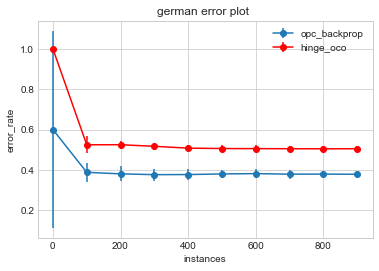

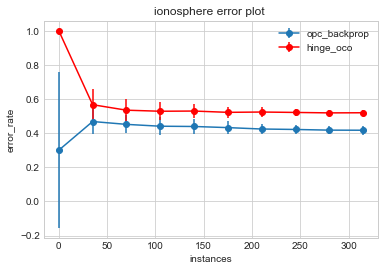

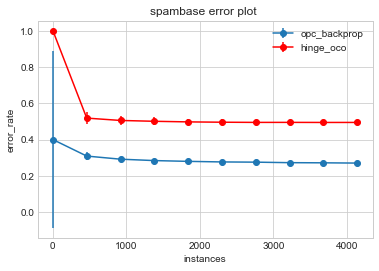

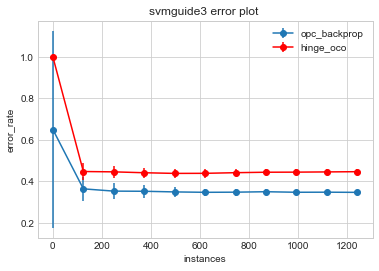

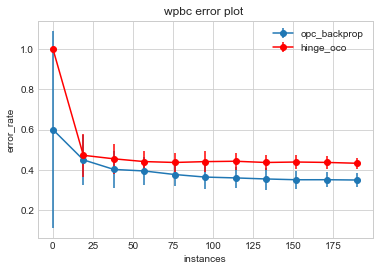

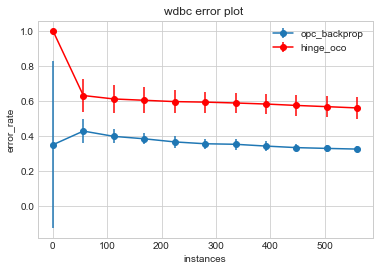

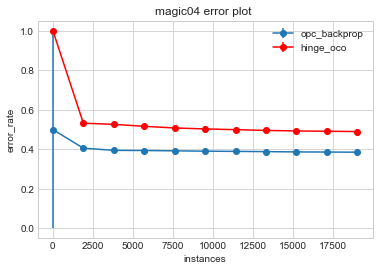

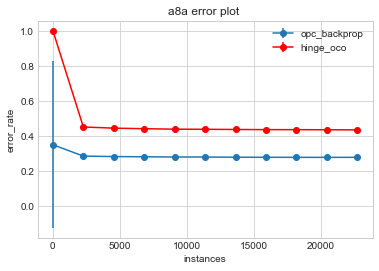

In [4]:

for data_set in datasets:
    plot(results,instances_track,data_set)